## Quantum energy teleportation protocol with minimal model

### Import packages

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import transpile

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as sampler
from qiskit.visualization import plot_histogram

### Function to generate a circuit that measures the interaction term $X_0X_1$ or $V$

In [28]:
def qc_V(h,k):

    # Create circuit
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)
    
    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,qr[0])
    qc.cx(qr[0],qr[1])

    qc.barrier()

    # Projective measurement of A
    qc.h(qr[0])

    qc.barrier()

    # Condicional operation on B
    phi = 0.5*np.arcsin((h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2))

    qc.cry(-2*phi,qr[0],qr[1])

    qc.x(qr[0])
    qc.cry(2*phi,qr[0],qr[1])
    qc.x(qr[0])

    # Measurement of the interaction term V
    qc.h(qr[1])
    qc.measure_all()

    return qc


### Function to generate a circuit that measures the local term $Z_1$ or $H_1$

In [ ]:
def qc_H(h,k):

    # Generate circuit
    qr = QuantumRegister(2)
    qc = QuantumCircuit(qr)

    #Prepare the ground state
    theta = -np.arcsin((1/np.sqrt(2))*(np.sqrt(1+h/np.sqrt(h**2+k**2))))

    qc.ry(2*theta,qr[0])
    qc.cx(qr[0],qr[1])
    
    qc.barrier()

    # Projective measurement on A
    qc.h(qr[0])

    qc.barrier()

    # Condicional operation on B
    phi = 0.5*np.arcsin((h*k)/np.sqrt((h**2+2*k**2)**2+(h*k)**2))

    qc.cry(-2*phi,qr[0],qr[1])
    
    qc.x(qr[0])
    qc.cry(2*phi,qr[0],qr[1])
    qc.x(qr[0])

    # measurement of Bob's Z term
    qc.measure_all()

    return qc

### Show quantum circuit

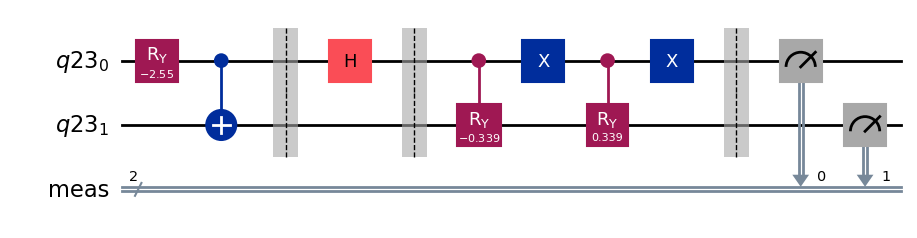

In [39]:
qc = qc_H(1.5, 1)
qc.draw('mpl')

### Simulate circuit $V$ with aer simulator

In [35]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1.5; k = 1;
n_shots = 100000

# Generate circuit
qc = qc_V(h, k)
qc_A = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobA_sim = sampler().run([qc_A], shots=n_shots)

### Simulate circuit H with aer simulator

In [36]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h = 1.5; k = 1;
n_shots = 100000

# Generate circuit
qc = qc_H(h, k)
qc_B = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobB_sim = sampler().run([qc_B], shots=n_shots)

### Show results for simulated circuit V

Exact E_A =  1.2480754415067656
Alice's local energy =  1.2486454415067656 ± 0.004743416147777887
Interacting energy, V =  -0.4876396075495417 ± 0.006324554954777449


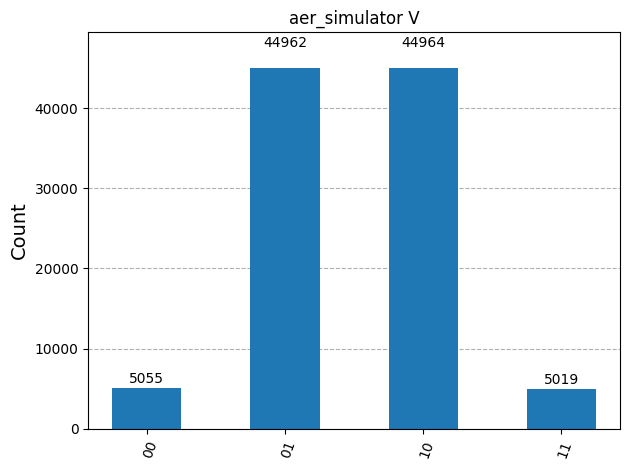

In [ ]:

result = jobA_sim.result()[0]
counts = result.data.meas.get_counts()


ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

error_A = []
error_V = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_V.append(2*k*(-1)**(int(bit_string[1])))

print("Exact E_A =",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy =",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Interacting energy, V =",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title='aer_simulator V')

### Show results for simulated circuit $H$

In [ ]:

result = jobB_sim.result()[0]
counts = result.data.meas.get_counts()

ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B=(h**2)/(np.sqrt(h**2+k**2))

error_A = []
error_B = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

print("Exact E_0 =",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy =",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Bob's local energy, H_1 =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))

plot_histogram(counts, title="aer_simulator H")

NameError: name 'jobB_sim' is not defined

### Get backend and its properties

In [ ]:
# Log in IBM platoform
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

# Select least busy backend
backend = service.least_busy(operational=True)

# Get backend properties
props = backend.properties()

# Function to select specific properties
def describe_qubit(qubit, properties):
    """Print a string describing some of reported properties of the given qubit."""

    # Conversion factors from standard SI units
    us = 1e6
    ns = 1e9
    GHz = 1e-9

    print("Backend = {6}\n"
          "Qubit {0} has a \n"
          "  - T1 time of {1} microseconds\n"
          "  - T2 time of {2} microseconds\n"
          "  - U2 gate error of {3}\n"
          "  - U2 gate duration of {4} nanoseconds\n"
          "  - resonant frequency of {5} GHz".format(
              qubit,
              properties.t1(qubit) * us,
              properties.t2(qubit) * us,
              properties.gate_error('sx', qubit),
              properties.gate_length('sx', qubit) * ns,
              properties.frequency(qubit) * GHz,
              backend.name))

describe_qubit(0, props)

Backend = ibm_kyiv
Qubit 0 has a 
  - T1 time of 397.7145290786901 microseconds
  - T2 time of 385.6892515765576 microseconds
  - U2 gate error of 0.00024628156915416807
  - U2 gate duration of 49.77777777777777 nanoseconds
  - resonant frequency of 4.655633112337349 GHz


### Run job in IBM Backend

In [ ]:
# Import Sampler and Batch mode
from qiskit_ibm_runtime import Batch, SamplerV2 as sampler

# Parameters h and k
variables = [(1,0.2),(1,0.5),(1,1),(1.5,1)]

# Run job in Batch mode
with Batch(backend=backend):
    n_shots = 5000

    for variable in variables:
        h = variable[0]
        k = variable[1]

        # Generate circuits V and H
        circuit_V = qc_V(h,k)
        qc_A = transpile(circuit_V, backend=backend, optimization_level=3)
        
        circuit_H = qc_H(h,k)
        qc_B = transpile(circuit_H, backend=backend, optimization_level=3)

        # Run jobs for each circuit
        job_A = sampler().run([(qc_A)], shots=n_shots)
        print("ID ="job_A.job_id(), "h ="h,"k ="k)

        job_B = sampler().run([(qc_B)], shots=n_shots)
        print("ID ="job_B.job_id(), "h ="h,"k ="k) 

czywkf5qnmvg008w5es0
czywkgpkzhn0008dawjg
czywkhynhqag008ttppg


qiskit_runtime_service.check_pending_jobs:WARNING:2025-04-14 22:51:55,290: The pending jobs limit has been reached. Waiting for job <RuntimeJobV2('czywkf5qnmvg008w5es0', 'sampler')> to finish before submitting the next one.


czywm38d8drg008hyyt0
czywm4rkzhn0008dawr0
czywm60d8drg008hyywg


qiskit_runtime_service.check_pending_jobs:WARNING:2025-04-14 22:53:16,851: The pending jobs limit has been reached. Waiting for job <RuntimeJobV2('czywm38d8drg008hyyt0', 'sampler')> to finish before submitting the next one.


czywm7rnhqag008ttpvg
czywm91qnmvg008w5f00


### Show results for circuit V

Exact E_A 1.2480754415067656
Alice's local energy 1.2564754415067658 STD is 0.02121112443978395
Interacting energy V 0.46060039245045836 STD is 0.028268866266619175


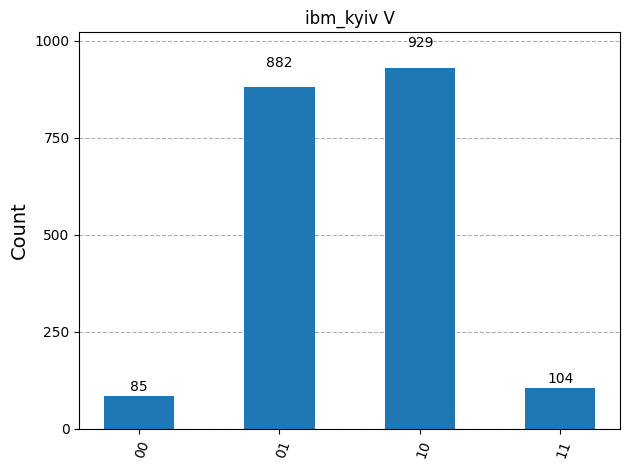

In [ ]:
# Select job ID
jobA = service.job('cybwydh9b62g008j8xk0')

result = jobA.result()[0]
counts = result.data.meas.get_counts()

# Parameters 
k = 1;h = 1.5;

ene_A=(h**2)/(np.sqrt(h**2+k**2))
ene_V=(2*k**2)/(np.sqrt(h**2+k**2))

error_A=[]
error_V=[]
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_V.append(2*k*(-1)**(int(bit_string[1])))

print("Theorical value for Alice local energy (E_A) = ",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy = ",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Interacting energy V = ",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title=backend.name 'V')

Exact E_A 1.2480754415067656
Alice's local energy 1.2390754415067657 STD is 0.021210816815955012
Bob's local energy 0.8958754415067656 STD is 0.017173932281222028


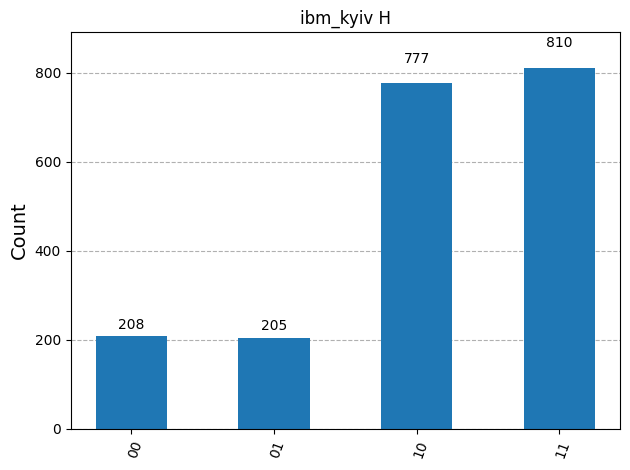

In [ ]:
jobB = service.job('cybwyf17v8tg008g0a70')
result = jobB.result()[0]
counts = result.data.meas.get_counts()

# parameters
k = 1;h = 1.5;

# 
ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_B=(h**2)/(np.sqrt(h**2+k**2))

error_A = []
error_B = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_B += h*(-1)**int(bit_string[1])*count/n_shots
        ene_A += h*(-1)**int(bit_string[0])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

print("Theoretical value for Alice local energy (E_A) =",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy =",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Bob's local energy =",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))

plot_histogram(counts, title=backend.name 'H')

In [26]:
cyemjfs9b62g008jkw20
cyemjj29b62g008jkw30
cyemjma9b62g008jkw3g
cyemjsv7v8tg008hbbhg
cyemjwb7v8tg008hbbjg
cyemjybcw2k0008r6k60
cyemk04nrmz00086ht0g
cyemk2wrta1g0088363g

NameError: name 'cyemjfs9b62g008jkw20' is not defined